In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch import tensor, sin, pi, exp
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import random_split, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## PINNs for solving PDEs

Physics Informed Neural Networks (PINNS) are neural networks that incorporate physics, often described by a PDE, into the training process. This allows the network to be more robust and generalizable by not only learning from the data but also adhering to the underlying physics describing the data. Here, the approach begins with a 1D example problem and is then generalized to solve eigenvalue problems in higher dimensions.

The idea here is to use neural networks to approximate the solution $u$ to this PDE, leveraging their well-known ability as universal function approximators and also automatic differentiation to differentiate the output with respect to their input coordinates.

## 1D problem

Consider the following reaction-diffusion equation in 1D
$$
\begin{align*}
    -\Delta u + u &= (m^2\pi^2+1)\sin(m\pi x),\hspace{10pt}\text{ in }(0,1)\\
    u(0)&=u(1)=0
\end{align*}
$$

This PDE can be solved analytically and the exact solution is given by $u(x) = \sin(m\pi x)$.

In [3]:
# RHS
def f(x,m=1):
    return (m**2*pi**2+1)*sin(m*pi*x)

# Exact Solution
def u_exact(x,m=1):
    return sin(m*pi*x)

### Creating neural network

In [4]:
# building PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 256),           # here 1 describes that we are working in 1D
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]

### Loss function

The key idea of PINNs is to incorporate the PDE directly into the loss function along with the boundary conditions. This can be thought of as penalizing the network prediction wherever it deviates from the governing PDE and boundary conditions. The gradients arising in the PDE can be easily computed using automatic differentiation.

The parameters of the neural networks can be learned by minimizing the mean-squared error loss function
$$
\begin{align*}
    MSE = MSE_u + MSE_f
\end{align*}
$$
where
$$
\begin{align*}
    MSE_b = |u(0)|^2 + |u(1)|^2
\end{align*}
$$
and
$$
\begin{align*}
    MSE_i = \frac{1}{N_i}\sum_{k=1}^{N_i} |-\Delta u(x_k) +u(x_k) - f(x_k)|^2
\end{align*}
$$
$N_i$ describes the number of collocation points which act as checkpoints to check whether the network prediction $u$ satisfies the PDE. $MSE_i$ describes the interior loss of network prediction, and $MSE_b$ describes the boundary loss. The collocation points, along with the endpoints, serve as training data for PINNs.

In [6]:
# computing loss function
def compute_loss(model: nn.Module, x_train: torch.Tensor,m=1):
    # evaluating u(x), f(x), du/dx, d^2u/dx^2 at training data points
    x_train.requires_grad_(True)
    u = model(x_train)
    du = grad(u,x_train)
    d2u = grad(du,x_train)

    residual = -d2u[1:-1] + u[1:-1] - f(x_train[1:-1],m)     # ODE-based interior residual
    interior_loss = torch.mean(residual ** 2)                # mean-squared interior loss

    # boundary residual for problem
    left_residual = u[0]
    right_residual = u[-1]
    boundary_loss = (left_residual ** 2 + right_residual ** 2)/2    # mean-squared boundary loss
    return interior_loss + boundary_loss

Note that as $m$ increases, the exact solution becomes more oscillatory, making it more difficult to approximate using PINNs.

### Generating Training and test dataset

The training set consists of uniformly spaced points in the interval, totaling $n_{train} = N_i+2$ points, where $N_i$ is the number of datapoints in the interior. Initially, the case where $m=1$ is studied, and then $m$ is incrementally increased to assess the performance of PINNs.

In [7]:
# generating the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)
x_train.shape

torch.Size([20, 1])

In [8]:
# generating the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
x_test.shape

torch.Size([100, 1])

In [9]:
# exact solution
u_true = u_exact(x_test)
u_true.shape

torch.Size([100, 1])

### Training and predicting using PINN

Here, LBFGS optimizer with learning rate 0.001 is used to minimize the loss function described above. 6% of the train set is used for validating the output of training process.

In [10]:
# defining a function to train PINN
def train_PINN(x_train,num_epochs,m=1,verbose = True):
    model = PINN().to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

    # defining the closure function for LBFGS optimizer
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(model, x_train, m)
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()                           # Set model to training mode
        train_loss = optimizer.step(closure)

        if epoch % 200 == 0 and verbose ==True:
            print(f"Full Training Epoch {epoch}, Training Loss: {train_loss.item():.6f}")

    return model

In [11]:
# training the model
num_epochs = 500
u = train_PINN(x_train,num_epochs)

Full Training Epoch 0, Training Loss: 63.509506
Full Training Epoch 200, Training Loss: 0.000004
Full Training Epoch 400, Training Loss: 0.000004


In [12]:
# Predicting using obtained u
u_pred = u(x_test)
u_pred.shape

torch.Size([100, 1])

In [13]:
# checking if the predicted and exact solution vectors have same size
u_pred.shape == u_true.shape

True

### Calculating $L^2$ error of the solution

In [ ]:
def L2_error(u_pred,u_true):
    return torch.mean((u_true-u_pred)**2)

In [15]:
error = L2_error(u_pred,u_true)
print(f"L2_error of approximation: {error}")

L2_error of approximation: 3.4274506788278813e-08


This shows that PINNs performs well for solving the ODE in the simplest case.

### Plotting the solution

In [16]:
# converting tensors to numpy arrays for plotting
x_train.requires_grad_(False)
x_train = x_train.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

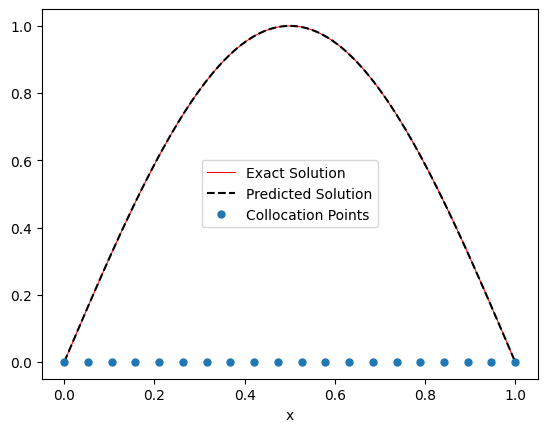

In [17]:
# plotting the exact and predicted solution along with the collocation points
plt.plot(x_test,u_true,label = "Exact Solution",linestyle="-",color = "red",linewidth = 0.75)
plt.plot(x_test,u_pred,label = "Predicted Solution",linestyle="--",linewidth = 1.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

### Convergence Study

The $L^2$ error is analyzed first by varying the number of training epochs, and subsequently by adjusting the size of the collocation (training) points.

In [18]:
epochs = [500,1000,2000,4000]          
L2_err = []

# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test)

for epoch in epochs:
    u = train_PINN(x_train,epoch,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,500.0,1.587170e-08
1,1000.0,6.973696e-09
2,2000.0,2.923546e-08
3,4000.0,1.238013e-08


As expected, the $L^2$ error consistently decreases as the number of training epochs increases. 

In [19]:
train_size = [10,20,40,80]
L2_err = []
num_epochs = 2000

# generate the test set
n_test = 500
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

    u = train_PINN(x_train,num_epochs,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,1.818100e-05
1,20.0,2.365628e-08
2,40.0,2.878256e-08
3,80.0,5.140846e-08


As observed in the table above, the size of the training set does not significantly affect the error.

Let us analyze the performance of PINNs as the solution becomes more oscillatory.

### Convergence Study for $m=2$

In [20]:
epochs = [500,1000,2000,4000]
L2_err = []
m=2
# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for epoch in epochs:
    u = train_PINN(x_train=x_train,num_epochs=epoch,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,500.0,0.000003
1,1000.0,0.000010
2,2000.0,0.000002
3,4000.0,0.000034


In [21]:
train_size =  [10,20,40,80]
L2_err = []
num_epochs = 2000
m=2

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

    u = train_PINN(x_train=x_train,num_epochs=num_epochs,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,0.013229
1,20.0,0.000003
2,40.0,0.000004
3,80.0,0.000004


In [22]:
# converting tensors to numpy arrays for plotting
x_train.requires_grad_(False)
x_train = x_train.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

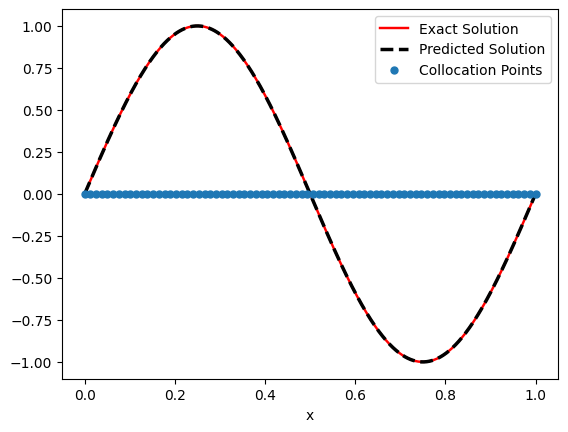

In [23]:
# plotting the exact and predicted solution for the last instance
plt.plot(x_test,u_true,label = "Exact Solution",linestyle="-",color = "red",linewidth = 1.75)
plt.plot(x_test,u_pred,label = "Predicted Solution",linestyle="--",linewidth = 2.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

### Convergence Study for $m=4$

In [24]:
epochs = [500,1000,2000,4000]
L2_err = []
m=4
# generate the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

# generate the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for epoch in epochs:
    u = train_PINN(x_train=x_train,num_epochs=epoch,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,500.0,0.001912
1,1000.0,2195.685059
2,2000.0,0.002141
3,4000.0,0.001437


In [25]:
train_size =  [10,20,40,80]
L2_err = []
num_epochs = 2000
m=4

# generate the test set
n_test = 1000
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
u_true = u_exact(x_test,m)

for n_train in train_size:
    # generate the training set
    x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)

    u = train_PINN(x_train=x_train,num_epochs=num_epochs,m=m,verbose=False)
    u_pred = u(x_test)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([train_size, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,944.449036
1,20.0,0.009516
2,40.0,0.000258
3,80.0,0.000322


In [26]:
x_train.requires_grad_(False)
x_train = x_train.detach().cpu().numpy()
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

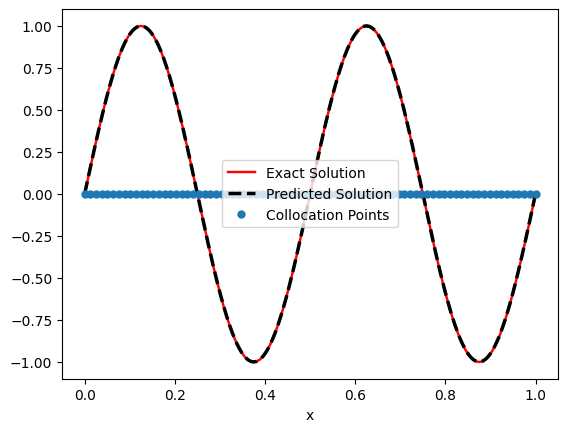

In [27]:
plt.plot(x_test,u_true,label = "Exact Solution",linestyle="-",color = "red",linewidth = 1.75)
plt.plot(x_test,u_pred,label = "Predicted Solution",linestyle="--",linewidth = 2.5,color = "black")
plt.plot(x_train,np.zeros_like(x_train),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
plt.xlabel("x")
plt.legend()
plt.show()

Approximating highly oscillatory solutions using PINNs is challenging. As demonstrated above, an increase in the parameter $m$ correlates with an increased number of epochs required to achieve a desired accuracy. This difficulty can be mitigated by increasing either the number of collocation points or the number of hidden layers in the neural network.

## 2D Problem

Consider the following two-dimensional problem
$$
\begin{align*}
    -\Delta u +u &= (m^2\pi^2+n^2\pi^2+1)\sin(m\pi x)\sin(n\pi y),\hspace{10pt}\text{ in }(0,1)\\
    u(0)&=u(1)=0
\end{align*}
$$

The exact solution is given by $u_{mn} = \sin(m\pi x)\sin(n \pi y)$.

In [28]:
# RHS
def f(x,m=1,n=1):
    return (m**2*pi**2+n**2*pi**2+1)*sin(m*pi*x[0])*sin(n*pi*x[1])

# Exact Solution
def u_exact(x,m=1,n=1):
    return sin(m*pi*x[0])*sin(n*pi*x[1])

### Creating PINN

In [29]:
# building PINN neural network using nn.Module class
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 256),          # here 2 describes that we are working in 2D
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.net(x)

# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True,retain_graph=True)[0]

### Loss function

Here, since the boundary is 1D we sample ennough points on the boundary to impose the boundary conditions into the loss function. That is, $MSE_b$ takes the form
$$
\begin{align*}
    MSE_b =\frac{1}{N_b}\sum_{k=1}^{N_b} |u(x_k)|^2
\end{align*}
$$

and $MSE_i$ has the same form except that the points are in 2D.

In [30]:
# computing loss function
def compute_loss(model: nn.Module, x_train_i: torch.Tensor,x_train_b:torch.Tensor,m=1,n=1):
    # evaluating u(x), f(x), du/dx, d^2u/dx^2 at training data points
    x_train = torch.cat([x_train_i,x_train_b])
    x_train.requires_grad_(True)
    u = model(x_train)
    u.requires_grad_(True)
    du = grad(u,x_train)
    du.requires_grad_(True)

    du_dx = du[:, 0].view(-1, 1)                          # du/dx component
    du_dy = du[:, 1].view(-1, 1)                          # du/dy component

    # calculating second derivatives: d^2u/dx^2 and d^2u/dy^2
    d2u_dx2 = grad(du_dx, x_train)[:, 0].view(-1, 1)      # Take x component again
    d2u_dy2 = grad(du_dy, x_train)[:, 1].view(-1, 1)      # Take y component again

    # computin the second derivative by taking the gradient of du with respect to the corresponding component of x_train
    d2u_dx2 = grad(du[:, 0], x_train)[:, 0].view(-1, 1)
    d2u_dy2 = grad(du[:, 1], x_train)[:, 1].view(-1, 1)
    d2u = d2u_dx2 + d2u_dy2

    # calculating interior loss for problem
    residual_i = -d2u[:len(x_train_i),0]  + u[:len(x_train_i),0] - f(x_train_i.T,m,n)        # PDE-based interior residual
    interior_loss = torch.mean(residual_i**2)                                                # mean-squared interior loss

    # calculating boundary loss for problem
    residual_b = u[len(x_train_i):,0]
    boundary_loss = torch.mean(residual_b**2)                                                 # mean-squared boundary loss

    return interior_loss + boundary_loss

### Generating Training and test dataset

In [31]:
# generating interior points on the square
def generate_collocation_points(N_i):
    xx = torch.linspace(0,1,N_i+2)[1:-1]
    yy = torch.linspace(0,1,N_i+2)[1:-1]
    x = []
    for i in range(len(xx)):
        for j in range(len(yy)):
            x.append([xx[i],yy[j]])
    return torch.tensor(x, dtype=torch.float32)

# generating boundary points
def generate_boundary_points(N_b):
    ref = torch.linspace(0,1,N_b+2)[1:-1]
    x = []
    for i in range(len(ref)):
        x.append([ref[i],0])
        x.append([ref[i],1])
        x.append([0,ref[i]])
        x.append([1,ref[i]])
    x.append([0,0])
    x.append([1,0])
    x.append([0,1])
    x.append([1,1])
    return torch.tensor(x, dtype=torch.float32)

The number of collocation points in the interior of square is $N_i^2$ and the number of boundary points are $4(N_b+1)$, where $N_i$ and $N_b$ are the inputs of `generate_collocation_points` and `generate_boundary_points` respectively.

In [32]:
# collocation points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)
x_train_i.shape

torch.Size([900, 2])

In [33]:
# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)
x_train_b.shape

torch.Size([60, 2])

In [34]:
# generating uniformly spaced points for test set on the closed square
def generate_test(N):
    xx = torch.linspace(0,1,N)
    yy = torch.linspace(0,1,N)
    x = []
    for i in range(len(xx)):
        for j in range(len(yy)):
            x.append([xx[i],yy[j]])
    return torch.tensor(x, dtype=torch.float32)

The test set consists of uniformly spaced points in $[0,1]$.

In [35]:
N = 35
x_test = generate_test(N).to(device)
x_test.shape

torch.Size([1225, 2])

In [36]:
u_true = u_exact(x_test.T)
u_true.shape

torch.Size([1225])

### Training and predicting using PINN

The loss function is minimized using the L-BFGS optimizer with a learning rate of 0.001. To monitor model performance, 5% of the training data is allocated for validation, and both training and validation losses are plotted.

In [37]:
# defining a function to train PINN
def train_PINN(x_train_i,x_train_b,num_epochs,m=1,n=1,verbose = True, create_graph = True):
    model = PINN().to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

    # initializing arrays for storing training and validation loss
    train_losses = []
    val_losses = []

    N_i_val = int(0.05*len(x_train_i))
    N_b_val = int(0.05*len(x_train_b))

    N_i_train = len(x_train_i) - N_i_val
    N_b_train = len(x_train_b) - N_b_val

    # splitting into training and validation
    x_training_i , x_validation_i = random_split(TensorDataset(x_train_i) , [N_i_train,N_i_val])
    x_training_b , x_validation_b = random_split(TensorDataset(x_train_b) , [N_b_train,N_b_val])

    x_training_i = x_training_i.dataset.tensors[0][x_training_i.indices].to(device)
    x_validation_i = x_validation_i.dataset.tensors[0][x_validation_i.indices].to(device)

    x_training_b = x_training_b.dataset.tensors[0][x_training_b.indices].to(device)
    x_validation_b = x_validation_b.dataset.tensors[0][x_validation_b.indices].to(device)


    # defining the closure function
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(model, x_training_i, x_training_b, m, n)
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        model.train()                                                         # Set model to training mode
        train_loss = optimizer.step(closure)

        model.eval()                                                          # Set model to evaluation mode
        val_loss = compute_loss(model, x_validation_i, x_validation_b, m, n)

        if epoch % 10 == 0:
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

        if epoch % 200 == 0 and verbose ==True:
            print(f"Full Training Epoch {epoch}, Training Loss: {train_loss.item():.6f}, Validation Loss: {val_loss.item():.6f}")

    # creating loss curves with epochs
    if create_graph == True:
        plt.plot(train_losses, label = "Training Loss")
        plt.plot(val_losses, label = "Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.xticks(ticks=range(0, len(train_losses) + 1, 100),labels = range(0, 10*len(train_losses) + 1, 1000))
        plt.title("Loss Curves")
        plt.legend()
        plt.grid(True)
        plt.show()
    return model

Full Training Epoch 0, Training Loss: 119.200699, Validation Loss: 53.354916
Full Training Epoch 200, Training Loss: 0.000052, Validation Loss: 0.000093
Full Training Epoch 400, Training Loss: 0.000028, Validation Loss: 0.000080
Full Training Epoch 600, Training Loss: 0.000028, Validation Loss: 0.000080
Full Training Epoch 800, Training Loss: 0.000028, Validation Loss: 0.000080
Full Training Epoch 1000, Training Loss: 0.000028, Validation Loss: 0.000080
Full Training Epoch 1200, Training Loss: 0.000028, Validation Loss: 0.000080
Full Training Epoch 1400, Training Loss: 0.000028, Validation Loss: 0.000080
Full Training Epoch 1600, Training Loss: 0.000028, Validation Loss: 0.000080
Full Training Epoch 1800, Training Loss: 0.000028, Validation Loss: 0.000080


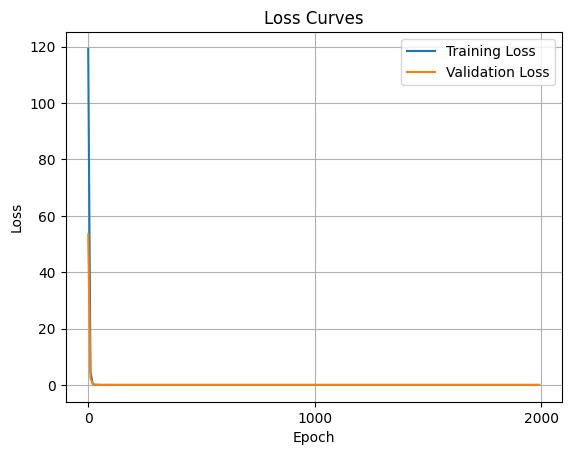

In [38]:
# training the model
num_epochs = 2000
u = train_PINN(x_train_i,x_train_b,num_epochs)

In [39]:
# Predicting using obtained u
u_pred = u(x_test)[:,0].to(device)
u_pred.shape

torch.Size([1225])

In [40]:
# checking if the predicted and exact solution vectors have same size
u_pred.shape == u_true.shape

True

### Calculating $L^2$ error of the solution

In [ ]:
def L2_error(u_pred,u_true):
    return torch.mean((u_true - u_pred)**2)

In [42]:
error = L2_error(u_pred,u_true)
print(f"L2_error of approximation: {error}")

L2_error of approximation: 0.0017380057834088802


### Plotting the solution

In [43]:
# converting tensors to numpy arrays for plotting
x_train_i.requires_grad_(False)
x_test = x_test.detach().cpu().numpy()
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

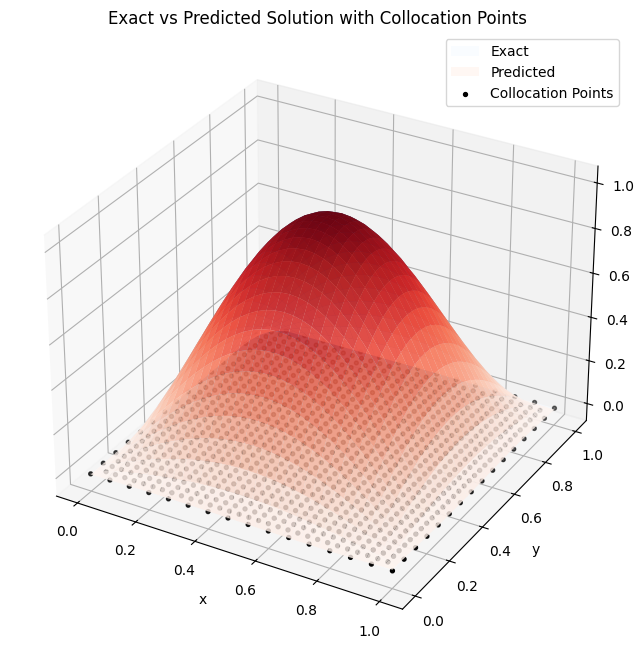

In [44]:
# Reshape test data for surface plots
N = int(np.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(N, N)
Y = x_test[:, 1].reshape(N, N)
u_pred = u_pred.reshape(N, N)
u_true = u_true.reshape(N, N)
x_train = np.vstack([x_train_i.detach().cpu().numpy(),x_train_b.detach().cpu().numpy()])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Surface: Exact solution
ax.plot_surface(X, Y, u_true, alpha = 0.7, cmap="Blues", label='Exact')

# Surface: Predicted solution (wireframe or different alpha)
ax.plot_surface(X, Y, u_pred, alpha = 0.8, cmap="Reds", label="Predicted")

# Scatter: Collocation points at z=0
ax.scatter(x_train[:, 0], x_train[:, 1], np.zeros_like(x_train[:, 0]),
           color='black', s=8, marker='o', label='Collocation Points')

# Labels and legend
ax.set_title("Exact vs Predicted Solution with Collocation Points")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.legend()
plt.show()

### Convergence Study

The $L^2$ error is analyzed first by varying the number of training epochs, and subsequently by adjusting the size of the collocation points and boundary points.

In [48]:
epochs = [1000,2000,4000]
L2_err = []

# interior points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# generating the test set
N = 35
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T)

for epoch in epochs:
    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=epoch,m=1,n=1,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table 

,Epochs,L2 error
0,1000.0,0.003473
1,2000.0,0.002254
2,4000.0,0.001971


In [49]:
N_i = [10,20,40,80]
L2_err = []
num_epochs = 3000

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T)

for n_train in N_i:
    # collocation points
    x_train_i = generate_collocation_points(n_train).to(device)

    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=num_epochs,m=1,n=1,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([N_i, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,0.027122
1,20.0,0.016912
2,40.0,0.008006
3,80.0,0.008333


In [50]:
N_b = [8,16,32]
L2_err = []
num_epochs = 3000

# collocation points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T)

for n_train in N_b:
    # boundary points
    x_train_b = generate_boundary_points(n_train).to(device)

    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=num_epochs,m=1,n=1,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([N_b, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,8.0,0.010631
1,16.0,0.011373
2,32.0,0.017385


As observed in the table above, the number of the collocation points or boundary points does not significantly affect the error.

### Convergence Study for $m=2$ and $n=1$

In [51]:
epochs = [1000,2000,4000]
L2_err = []
m=2
n=1

# interior points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# test set
N = 35
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T,m=m,n=n)

for epoch in epochs:
    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=epoch,m=m,n=n,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,1000.0,0.012526
1,2000.0,0.009345
2,4000.0,0.013500


In [52]:
N_i = [10,20,40,80]
L2_err = []
num_epochs = 3000

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T,m=m,n=n)

for n_train in N_i:
    # collocation points
    x_train_i = generate_collocation_points(n_train).to(device)

    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=num_epochs,m=m,n=n,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([N_i, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,131.896713
1,20.0,0.077838
2,40.0,0.066367
3,80.0,0.061213


In [53]:
N_b = [8,16,32]
L2_err = []
num_epochs = 3000

# collocation points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T,m=m,n=n)

for n_train in N_b:
    # boundary points
    x_train_b = generate_boundary_points(n_train).to(device)

    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=num_epochs,m=m,n=n,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([N_b, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,8.0,0.094052
1,16.0,0.095750
2,32.0,0.152641


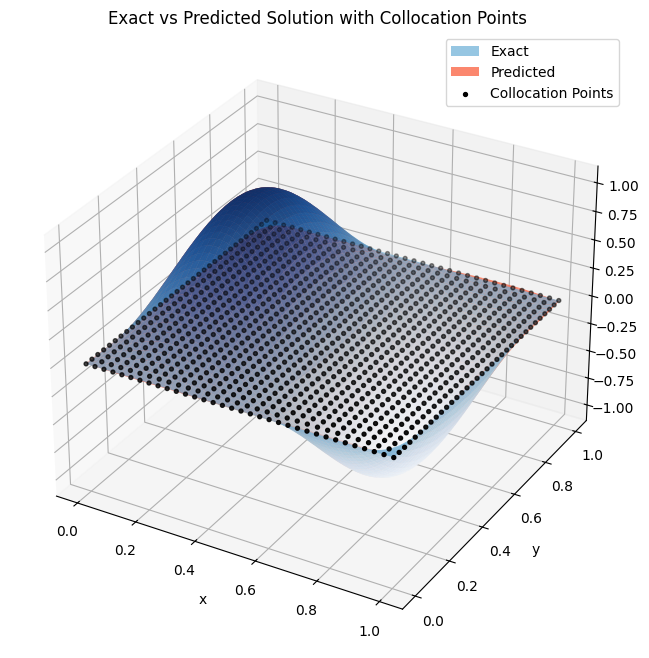

In [54]:
# Reshape test data for surface plots
N = int(np.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(N, N)
Y = x_test[:, 1].reshape(N, N)
u_pred = u_pred.reshape(N, N)
u_true = u_true.reshape(N, N)
x_train = np.vstack([x_train_i.detach().cpu().numpy(),x_train_b.detach().cpu().numpy()])
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Surface: Exact solution
ax.plot_surface(X, Y, u_true, alpha = 0.7, cmap="Blues", label='Exact')

# Surface: Predicted solution (wireframe or different alpha)
ax.plot_surface(X, Y, u_pred, alpha = 0.8, cmap="Reds", label="Predicted")

# Scatter: Collocation points at z=0
ax.scatter(x_train[:, 0], x_train[:, 1], np.zeros_like(x_train[:, 0]),
           color='black', s=8, marker='o', label='Collocation Points')

# Labels and legend
ax.set_title("Exact vs Predicted Solution with Collocation Points")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.legend()
plt.show()

### Convergence Study for $m=2$ and $n=2$

In [55]:
epochs = [1000,2000,4000]
L2_err = []
m=2
n=2

# interior points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# test set
N = 35
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T,m=m,n=n)

for epoch in epochs:
    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=epoch,m=m,n=n,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([epochs, L2_err]),columns=["Epochs","L2 error"])
table

,Epochs,L2 error
0,1000.0,0.035252
1,2000.0,0.073268
2,4000.0,0.008261


In [56]:
N_i = [10,20,40,80]
L2_err = []
num_epochs = 3000

# boundary points
N_b = 14
x_train_b = generate_boundary_points(N_b).to(device)

# test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T,m=m,n=n)

for n_train in N_i:
    # collocation points
    x_train_i = generate_collocation_points(n_train).to(device)

    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=num_epochs,m=m,n=n,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([N_i, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,10.0,2.641470
1,20.0,0.953421
2,40.0,0.188433
3,80.0,0.205127


As observed in the 1D case, approximating oscillatory solutions remains challenging here as well.

In [63]:
N_b = [8,16,32]
L2_err = []
num_epochs = 3000

# collocation points
N_i = 30
x_train_i = generate_collocation_points(N_i).to(device)

# test set
N = 100
x_test = generate_test(N).to(device)
u_true = u_exact(x_test.T,m=m,n=n)

for n_train in N_b:
    # boundary points
    x_train_b = generate_boundary_points(n_train).to(device)

    u = train_PINN(x_train_i=x_train_i,x_train_b=x_train_b,num_epochs=num_epochs,m=m,n=n,verbose=False,create_graph=False)
    u_pred = u(x_test)[:,0].to(device)

    L2_err.append(L2_error(u_pred,u_true).detach().cpu().numpy())

table = pd.DataFrame(data= np.transpose([N_b, L2_err]),columns=["Train size","L2 error"])
table

,Train size,L2 error
0,8.0,0.230052
1,16.0,NaN
2,32.0,0.141671


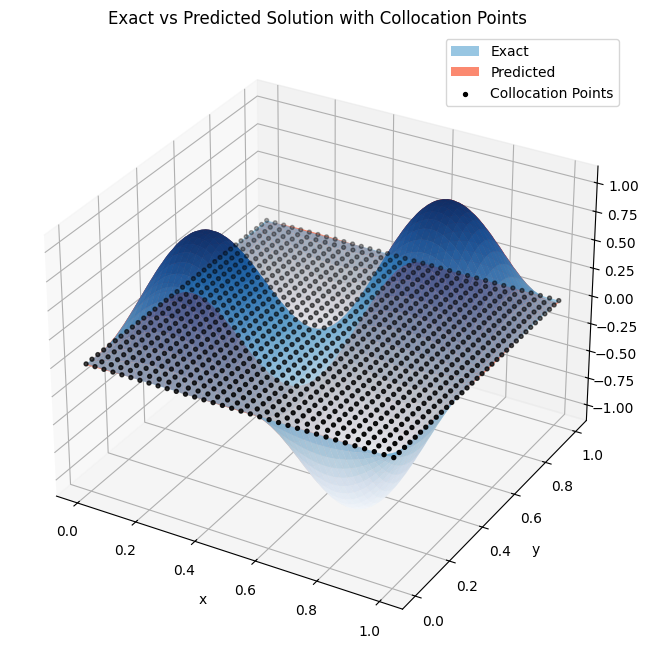

In [64]:
# Reshape test data for surface plots
N = int(np.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(N, N)
Y = x_test[:, 1].reshape(N, N)
u_pred = u_pred.reshape(N, N)
u_true = u_true.reshape(N, N)
x_train = np.vstack([x_train_i.detach().cpu().numpy(),x_train_b.detach().cpu().numpy()])
u_pred = u_pred.detach().cpu().numpy()
u_true = u_true.detach().cpu().numpy()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Surface: Exact solution
ax.plot_surface(X, Y, u_true, alpha = 0.7, cmap="Blues", label='Exact')

# Surface: Predicted solution (wireframe or different alpha)
ax.plot_surface(X, Y, u_pred, alpha = 0.8, cmap="Reds", label="Predicted")

# Scatter: Collocation points at z=0
ax.scatter(x_train[:, 0], x_train[:, 1], np.zeros_like(x_train[:, 0]),
           color='black', s=8, marker='o', label='Collocation Points')

# Labels and legend
ax.set_title("Exact vs Predicted Solution with Collocation Points")
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.legend()
plt.show()

## Advection equation in 1D

Consider the heat equation in 1D

$$
\begin{align*}
    \frac{\partial  u}{\partial t} &+ \frac{1}{2}\frac{\partial u}{\partial x}=0,\hspace{25pt}\text{ in }(0,1)\times [0,T]\\
    u(x,0) &= \sin(2m\pi x),\hspace{18pt}\text{ in }(0,1)\\
    u(0,t) &= u(1,t)\hspace{42pt}\text{ in }[0,T]
\end{align*}
$$

The exact solution of this equation is given by $u(x,t)= \sin(2m\pi(x-\frac{1}{2}t))$.

In [3]:
# initial condition
def u0(x,m=1):
    return sin(2*m*pi*x)

# exact solution
def u_exact(x,t,m=1):
    return sin(2*m*pi*(x-0.5*t))


$\textbf{Continuous Time Models:}$ One approach for solving time-dependent problems is to reframe them in the spatio-temporal domain, where time is treated as an additional coordinate. This allows the problem to be solved as a static partial differential equation (PDE) in the extended domain. We can use the method described above in this case.

$\textbf{Discrete Time Models:}$ Another approach is to break down the time evolution into a sequence of discrete time steps. A separate neural network is trained for each time step, or a single network is trained sequentially. The network for a given time step is trained to satisfy the PDE and the initial conditions provided by the solution from the previous time step.

### Discrete Time Models

The solution to the PDE is approximated at each time step using a neural network, which is trained on the solution approximated at the previous time step.

### Creating the network

A residual block consisting of two fully connected layers with a Tanh activation function is used. A skip connection is employed to add the block's input to its output, allowing the network to learn the residual function and facilitating the training of a deeper architecture.

In [26]:
class ResBlock(nn.Module):
    def __init__(self, size):
        super(ResBlock, self).__init__()
        # A simple block with two linear layers
        self.block = nn.Sequential(
            nn.Linear(size, size),
            nn.Tanh(),
            nn.Linear(size, size),
            nn.Tanh()
        )

    def forward(self, x):
        # Add the input 'x' to the output of the block
        return x + self.block(x)

# Build the main PINN network using ResBlocks
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            # Input layer
            nn.Linear(1, 256),
            nn.Tanh(),
            # Several residual blocks
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

In [27]:
# incorporating automatic differentiation
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]

### Loss function

The loss function can be formulated by using suitable time stepping method for $\frac{\partial u}{\partial t}$ given on the left hand side. For example, the backward Euler time integration gives

$$
\begin{align*}
    \frac{\partial u}{\partial t} \approx &\frac{u^{(n+1)} - u^{(n)}}{\Delta t} = -\frac{1}{10}u_{xx}^{(n+1)}
\end{align*}
$$

Then, the loss function at $t_{n+1}$ can be formulated as 
$$
\begin{align*}
    SSE^{(n+1)} = SSE_i^{(n+1)} + SSE_b^{(n+1)},
\end{align*}
$$
where 
$$
\begin{align*}
    SSE_i^{(n+1)} &= \sum_{i=1}^{N} |u^{(n+1)}-u^{(n)} + \frac{\Delta t}{10}u_{xx}^{(n+1)}|^2,\\
    SSE_b^{(n+1)} &= |u(0,t_{n+1})-u(1,t_{n+1})|^2,
\end{align*}
$$
and $u^{(i)}$'s are netwrok predictions at $t_i$.

Here, the loss function is computed using the 4th-order Runge Kutta method for time stepping.

In [ ]:
# computing initial condition loss 
def initial_condition_loss(u_prev_net, u0, x_train):
    u_prev = u_prev_net(x_train)
    u_0 = u0(x_train)
    return torch.sum((u_prev - u_0)**2)

In [ ]:
# computing the second spatial derivative of a given tensor.
def A_op(u_val, x_input):
    x_input.requires_grad_(True)
    u_val.requires_grad_(True) 
    du = grad(u_val, x_input)
    return  -0.5*du

def compute_loss(u_net: nn.Module, u_prev_net: nn.Module,x_train: torch.tensor,dt: float,is_first_step: bool, u0=u0):
    # evaluating u(x) and using 4th-order Runge-Kutta method for time stepping
    x_train.requires_grad_(True)

    # getting the output from the previous network (u_n)
    u_prev = u_prev_net(x_train) 
    
    # compute RK4 stages (k1, k2, k3, k4)
    k1 = A_op(u_prev, x_train)
    # k1 = -0.1*grad(u_prev, x_train)

    u_temp_k2 = u_prev + (dt/2) * k1
    k2 = A_op(u_temp_k2, x_train)
    # k2 = -0.1*grad(u_temp_k2, x_train)

    u_temp_k3 = u_prev + (dt/2) * k2
    k3 = A_op(u_temp_k3, x_train)
    # k3 = -0.1*grad(u_temp_k3, x_train)

    u_temp_k4 = u_prev + dt * k3
    k4 = A_op(u_temp_k4, x_train)
    # k4 = -0.1*grad(u_temp_k4, x_train)
    
    # the RK4 approximation 
    rk4_rhs = (u_prev + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)).detach()

    # the current model's prediction for the next time step (u_{n+1})
    u = u_net(x_train)

    # physics loss is now the difference between u_{n+1} and the RK4 RHS
    residual = u - rk4_rhs
    interior_loss = torch.sum(residual**2)

    # boundary condition loss
    boundary_loss = (u[0]- u[-1])**2

    # adding initial condition loss in the first time step
    if is_first_step:
        ic_loss = initial_condition_loss(u_prev_net,u0,x_train)
        return interior_loss + boundary_loss + ic_loss

    return interior_loss + boundary_loss

### Generating Training and test dataset

In [47]:
# generating the training set
n_train = 20
x_train = torch.linspace(0,1,n_train).reshape(-1,1).to(device)
x_train.shape

torch.Size([20, 1])

In [48]:
# generating the test set
n_test = 100
x_test = torch.linspace(0,1,n_test).reshape(-1,1).to(device)
x_test.shape

torch.Size([100, 1])

### Training and predicting using PINN

The Adam optimizer, combined with an early stopping criterion, is used to minimize the loss function. This approach ensures efficient training and prevents overfitting by halting the optimization process once the model's performance on the training data ceases to improve.

In [ ]:
# training function for a single time step
def train_PINN(u_prev_net, x_train, dt, num_epochs=1000,is_first_step = False, verbose=True):
    u_net = PINN().to(device)
    optimizer = torch.optim.Adam(u_net.parameters(), lr=0.001)   # using Adam optimizer

    for epoch in range(num_epochs):
        u_net.train()
        optimizer.zero_grad()
        
        # calculate loss
        loss = compute_loss(u_net, u_prev_net,x_train,dt,is_first_step)
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0 and verbose:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
                        
    return u_net

### Calculating $L^2$ error of the solution

In [56]:
def L2_error(u_pred,u_true):
    return torch.mean((u_true - u_pred)**2)

### Approximating the solution at discrete time steps

The 1D advection equation is solved using RK4 time-stepping, where at each step a new network is trained based on the previous solution, the prediction is compared with the exact solution, visualized, and its L2 error is recorded.

--------------------------------------------------------------------------------
Time step: 0.100
Epoch 0, Loss: 22.213050842285156
Epoch 500, Loss: 0.0004604883142746985
Epoch 1000, Loss: 0.0027478861156851053
Epoch 1500, Loss: 0.00046156311873346567
Epoch 2000, Loss: 0.002120930701494217
Epoch 2500, Loss: 0.0009240474319085479
Epoch 3000, Loss: 0.0032901642844080925
Epoch 3500, Loss: 0.0013996985508129


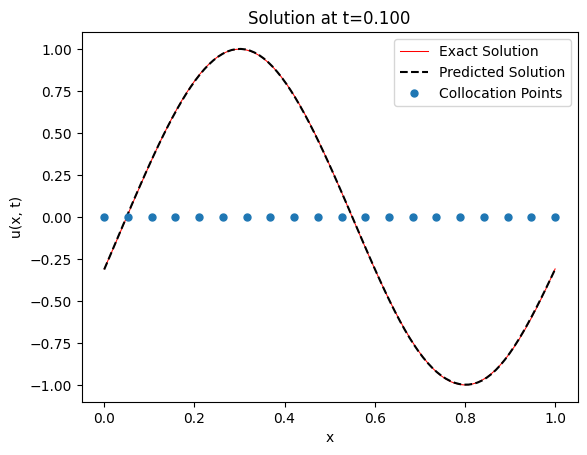

--------------------------------------------------------------------------------
Time step: 0.200
Epoch 0, Loss: 10.807915687561035
Epoch 500, Loss: 0.0015718636568635702
Epoch 1000, Loss: 0.0033315313048660755
Epoch 1500, Loss: 0.01067290734499693
Epoch 2000, Loss: 0.016450069844722748
Epoch 2500, Loss: 0.0007568859728053212
Epoch 3000, Loss: 0.015575476922094822
Epoch 3500, Loss: 0.01340268924832344


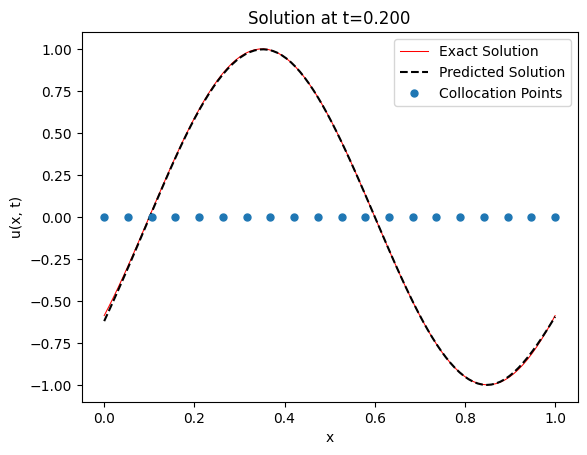

--------------------------------------------------------------------------------
Time step: 0.300
Epoch 0, Loss: 14.213445663452148
Epoch 500, Loss: 0.03626649081707001
Epoch 1000, Loss: 0.0037549370899796486
Epoch 1500, Loss: 0.0036900986451655626
Epoch 2000, Loss: 0.0036370884627103806
Epoch 2500, Loss: 0.004164823796600103
Epoch 3000, Loss: 0.00371526088565588
Epoch 3500, Loss: 0.1511264592409134


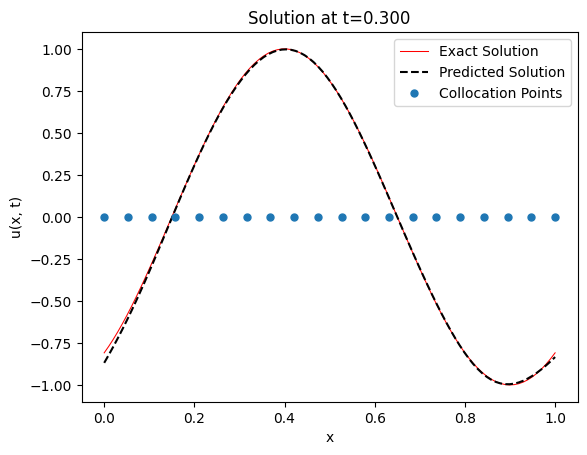

--------------------------------------------------------------------------------
Time step: 0.400
Epoch 0, Loss: 12.039999008178711
Epoch 500, Loss: 0.009903873316943645
Epoch 1000, Loss: 0.038472145795822144
Epoch 1500, Loss: 0.011103477329015732
Epoch 2000, Loss: 0.007761696353554726
Epoch 2500, Loss: 0.006498437374830246
Epoch 3000, Loss: 0.006364255212247372
Epoch 3500, Loss: 0.006673307158052921


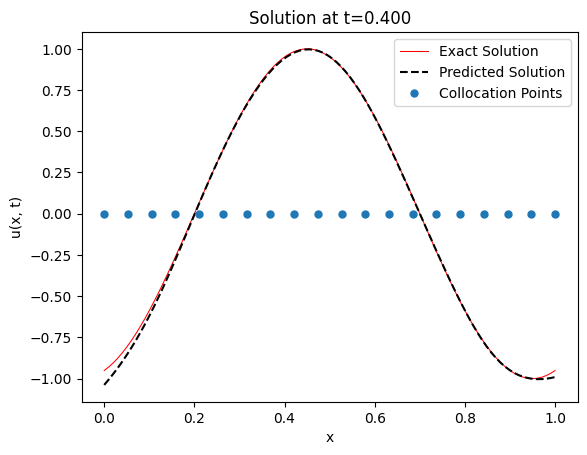

--------------------------------------------------------------------------------
Time step: 0.500
Epoch 0, Loss: 13.267013549804688
Epoch 500, Loss: 0.011038054712116718
Epoch 1000, Loss: 0.010828811675310135
Epoch 1500, Loss: 0.010721961036324501
Epoch 2000, Loss: 0.01066525373607874
Epoch 2500, Loss: 0.010599937289953232
Epoch 3000, Loss: 0.010935971513390541
Epoch 3500, Loss: 0.01054859533905983


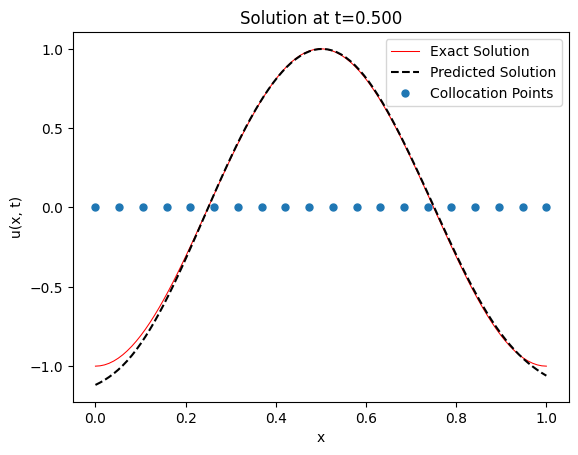

--------------------------------------------------------------------------------
Time step: 0.600
Epoch 0, Loss: 11.163755416870117
Epoch 500, Loss: 0.015899168327450752
Epoch 1000, Loss: 0.01667609252035618
Epoch 1500, Loss: 0.01549829263240099
Epoch 2000, Loss: 0.015301122330129147
Epoch 2500, Loss: 0.015100028365850449
Epoch 3000, Loss: 0.014959149062633514
Epoch 3500, Loss: 0.022294843569397926


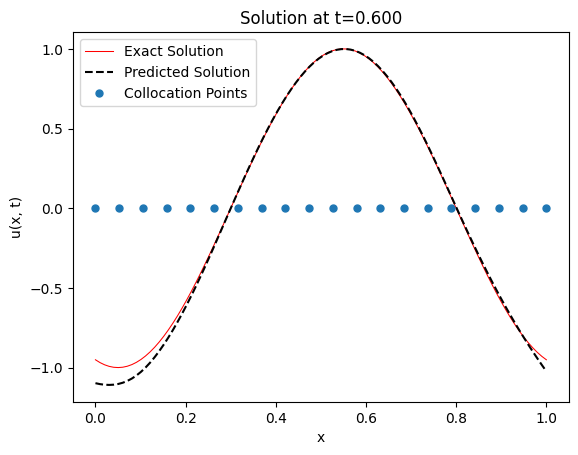

--------------------------------------------------------------------------------
Time step: 0.700
Epoch 0, Loss: 14.350805282592773
Epoch 500, Loss: 0.02076139487326145
Epoch 1000, Loss: 0.01924237050116062
Epoch 1500, Loss: 0.019176512956619263
Epoch 2000, Loss: 0.018927542492747307
Epoch 2500, Loss: 0.6534454226493835
Epoch 3000, Loss: 0.018969755619764328
Epoch 3500, Loss: 0.021139467135071754


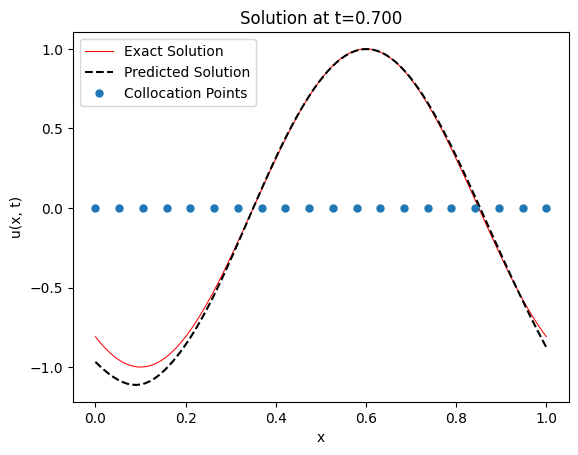

--------------------------------------------------------------------------------
Time step: 0.800
Epoch 0, Loss: 13.448535919189453
Epoch 500, Loss: 0.016168873757123947
Epoch 1000, Loss: 0.07047635316848755
Epoch 1500, Loss: 0.015312020666897297
Epoch 2000, Loss: 0.019502168521285057
Epoch 2500, Loss: 0.015856347978115082
Epoch 3000, Loss: 0.015461869537830353
Epoch 3500, Loss: 0.017679207026958466


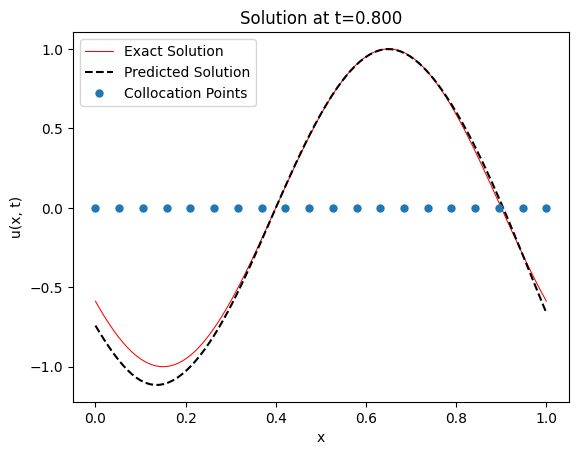

--------------------------------------------------------------------------------
Time step: 0.900
Epoch 0, Loss: 11.250685691833496
Epoch 500, Loss: 0.01483813114464283
Epoch 1000, Loss: 0.018698550760746002
Epoch 1500, Loss: 0.010556716471910477
Epoch 2000, Loss: 0.12146669626235962
Epoch 2500, Loss: 0.010862061753869057
Epoch 3000, Loss: 0.13708655536174774
Epoch 3500, Loss: 0.010962648317217827


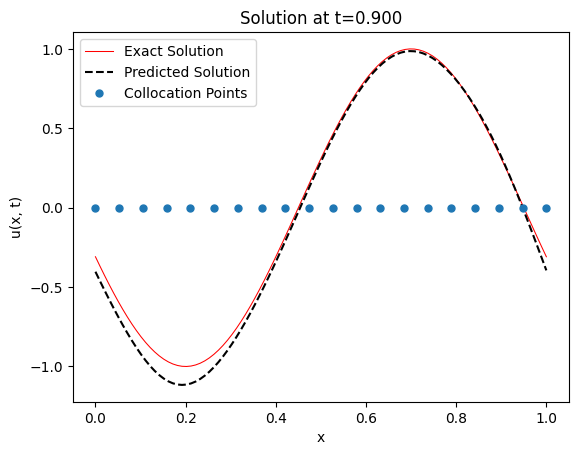

--------------------------------------------------------------------------------
Time step: 1.000
Epoch 0, Loss: 11.388456344604492
Epoch 500, Loss: 0.0034788409247994423
Epoch 1000, Loss: 0.006331845186650753
Epoch 1500, Loss: 0.0032864687964320183
Epoch 2000, Loss: 0.023302443325519562
Epoch 2500, Loss: 0.039237696677446365
Epoch 3000, Loss: 0.015837810933589935
Epoch 3500, Loss: 0.0026042344979941845


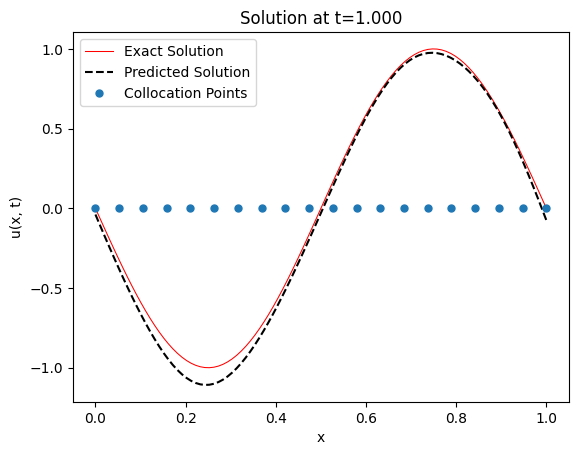

--------------------------------------------------------------------------------
Time step: 1.100
Epoch 0, Loss: 9.155089378356934
Epoch 500, Loss: 0.03156030923128128
Epoch 1000, Loss: 0.0021364169660955667
Epoch 1500, Loss: 0.0011394231114536524
Epoch 2000, Loss: 0.0025069983676075935
Epoch 2500, Loss: 0.05603043735027313
Epoch 3000, Loss: 0.026738468557596207
Epoch 3500, Loss: 0.005241789389401674


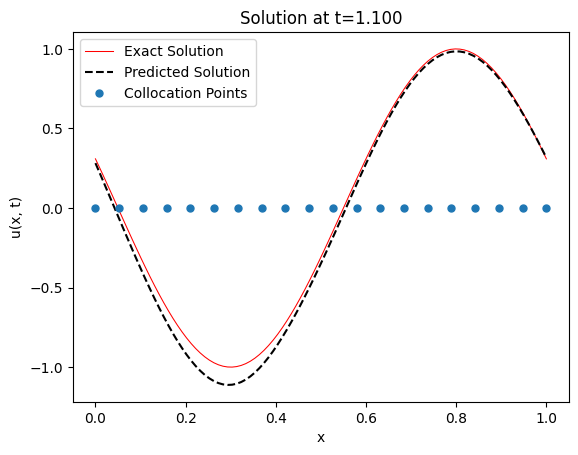


L2 Errors over Time Steps:


,Time Steps,L2_err
0,0.1,0.000004
1,0.2,0.000046
2,0.3,0.000164
3,0.4,0.000412
4,0.5,0.000920
5,0.6,0.001743
6,0.7,0.002740
7,0.8,0.003900
8,0.9,0.003720
9,1.0,0.003169


In [57]:
T = 1                               # final time
n_steps = 11                        # number of time steps

dt = T/(n_steps-1)                  # time step
t_steps = []
L2_err = []

# creating a network to represent the initial condition
class InitialConditionNet(nn.Module):
    def __init__(self, u0_func):
        super().__init__()
        self.u0_func = u0_func
    def forward(self, x):
        # Ensure x requires grad if passed to u0_func
        x.requires_grad_(True) 
        return self.u0_func(x)

# initializing u_p_net with the initial condition
u_prev_net = InitialConditionNet(u0).to(device)

num_epochs = 4000
t = 0.0
while t < T:                                        # loop until t reaches T
    print("-"*80)
    print(f"Time step: {t+dt:.3f}")

    is_first_step = (t == 0.0)                      # checking for the first step
    # training the current time step's network
    u_net = train_PINN(u_prev_net, x_train, dt, num_epochs,is_first_step)
    u_pred = u_net(x_test)                          # predicting at t + dt
    
    t += dt
    t_steps.append(t)                               # recording the current time

    u_true = u_exact(x_test, t)                     # exact solution for current time
    err = L2_error(u_pred, u_true)
    L2_err.append(err.detach().cpu().numpy())
    
    # updating u_p_net for the next step
    u_prev_net = PINN().to(device)                     
    u_prev_net.load_state_dict(u_net.state_dict())     # loading the learned weights
    

    # converting tensors to numpy arrays for plotting
    x_train_plot = x_train.detach().cpu().numpy()
    x_test_plot = x_test.detach().cpu().numpy()
    u_pred_plot = u_pred.detach().cpu().numpy()
    u_true_plot = u_true.detach().cpu().numpy()

    # plotting the exact and predicted solution along with the collocation points
    plt.plot(x_test_plot,u_true_plot,label = "Exact Solution",linestyle="-",color = "red",linewidth = 0.75)
    plt.plot(x_test_plot,u_pred_plot,label = "Predicted Solution",linestyle="--",linewidth = 1.5,color = "black")
    plt.plot(x_train_plot,np.zeros_like(x_train_plot),label="Collocation Points",linestyle = "None", marker = "o",markersize  =5)
    plt.title(f"Solution at t={t:.3f}")
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.legend()
    plt.show()

# displaying L2 errors
table = pd.DataFrame(data=np.transpose([t_steps, L2_err]), columns=["Time Steps", "L2_err"])
print("\nL2 Errors over Time Steps:")
table